In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Lecture 09
## Introduction to Pytorch - Framework Demo
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset
- pytorch implementation Custom Dataset Class with loader


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
modelSubDir = 'pytorch_fifa'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 51 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, modelSubDir)):
    os.makedirs(os.path.join(modelDir, modelSubDir))
    print ('Created {} directory'.format(os.path.join(modelDir, modelSubDir)))

## Read FIFA 2019 data set
<img src = '../../images/fifa_2019.png' alt = 'Fifa 2019'>

In [5]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [6]:
# removing rows with position == null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [7]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [8]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [9]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Helps in preventing pandas from complaining while get_dummies
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [10]:
class_labels = {0: 'GK', 1: 'Defender', 2: 'Mid Fielder', 3 : 'Forward'}

In [11]:
# Keeping relevent columns.
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [12]:
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
train_df.shape, test_df.shape

((14517, 34), (3630, 34))

## All about CUDA

In [13]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [14]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [15]:
## Singleton Class

In [16]:
'''Using Singleton design pattern'''

class GlobalScaler:
    _instance = None
    
    def __init__ (self):
        if GlobalScaler._instance is not None:
            raise Exception ("GlobalScaler class is a singleton.")
        self.scaler = StandardScaler()
        
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScaler()
        return cls._instance

In [17]:
globalScaler = GlobalScaler.get_instance()
globalScaler.scaler

StandardScaler()

In [18]:
'''
In this code, we define a custom dataset called FifaDS that takes a DataFrame as input. 

'''

class FifaDS(Dataset):
    globalScaler = GlobalScaler.get_instance() # private instance variable
    
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 device : str = device, 
                 is_train = True,
                 label_col = None
                ):
        
        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.scaler = self.globalScaler.scaler
        self.label_col = label_col
        
        self.labels = self.df[label_col].to_numpy()
        X = self.df.drop(label_col, axis = 1)
        
        if self.is_train:
            self.features = self.scaler.fit_transform(X) # fit transform train set 
        else:
            self.features = self.scaler.transform(X) # transform only test set 
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, 
                                dtype=torch.float32, 
                                device=self.device)
        
        label = torch.tensor(label, 
                             dtype=torch.int64, 
                             device=self.device)
        
        return features, label

In [19]:
label_col = 'Position'

train_ds = FifaDS(train_df, is_train=True, label_col=label_col)

test_ds = FifaDS(test_df, is_train=False, label_col=label_col)


In [20]:
next(iter(train_ds))

(tensor([ 0.8440,  0.2736, -0.5224,  0.2311,  0.2971, -0.2802, -0.9055, -0.7692,
          0.0364,  0.6969,  0.5615,  0.6422, -0.3119,  0.4269,  0.0910, -0.0058,
         -0.0157, -0.2691,  0.1495, -0.3957, -1.5856,  0.5660, -0.4513,  0.9238,
         -0.5824, -1.3197, -1.4632, -1.5835, -0.3178, -0.5550, -0.3775, -0.2574,
         -0.3184], device='cuda:0'),
 tensor(3, device='cuda:0'))

In [21]:
input_shape = train_df.shape[1] -1
input_shape

33

In [22]:
class Model(nn.Module):
    
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,16)
        self.activ1 = nn.SiLU()
        self.layer2 = nn.Linear(16, 4)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        x = F.softmax(self.layer2(x), dim = 1)
        return x

net = Model(input_dim=input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (activ1): SiLU()
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [23]:
train_loader = DataLoader(train_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(test_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

In [24]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:1.0348, test:0.9216 | Acc - train:0.7581, test:0.8281
At epoch 5 | Loss - train:0.8696, test:0.8785 | Acc - train:0.8759, test:0.8647
At epoch 10 | Loss - train:0.8631, test:0.8717 | Acc - train:0.8801, test:0.8697
At epoch 15 | Loss - train:0.8597, test:0.8691 | Acc - train:0.8856, test:0.8722
At epoch 20 | Loss - train:0.8577, test:0.8664 | Acc - train:0.8857, test:0.8758
At epoch 25 | Loss - train:0.8561, test:0.8661 | Acc - train:0.8883, test:0.8758
At epoch 30 | Loss - train:0.8548, test:0.8643 | Acc - train:0.8898, test:0.8771
At epoch 35 | Loss - train:0.8533, test:0.8640 | Acc - train:0.8914, test:0.8777
At epoch 40 | Loss - train:0.8525, test:0.8625 | Acc - train:0.8912, test:0.8807
At epoch 45 | Loss - train:0.8516, test:0.8635 | Acc - train:0.8923, test:0.8769
At epoch 50 | Loss - train:0.8510, test:0.8649 | Acc - train:0.8938, test:0.8782


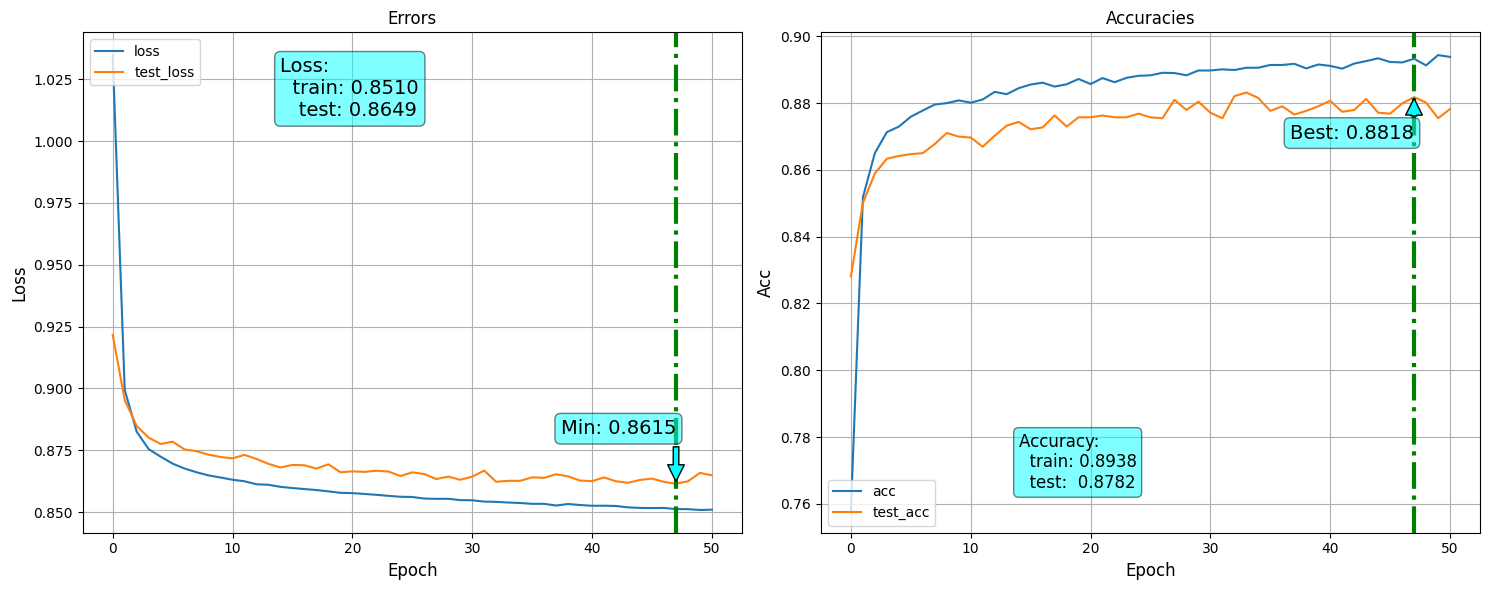

In [25]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
fn_plot_torch_hist(loss_df)

In [26]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [27]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.94      0.93      4693
           2       0.86      0.86      0.86      5470
           3       0.85      0.81      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.91     14517
weighted avg       0.89      0.89      0.89     14517



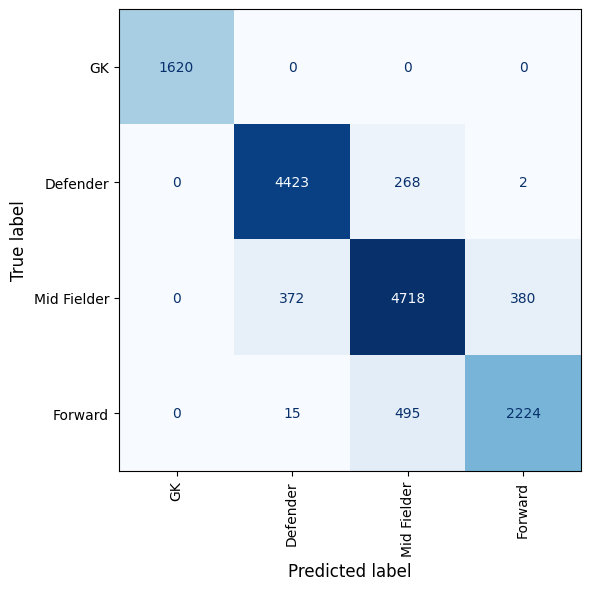

In [28]:
fn_plot_confusion_matrix(y_train, y_pred, class_labels)

In [29]:
y_test = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.94      0.93      4693
           2       0.86      0.86      0.86      5470
           3       0.85      0.81      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.91     14517
weighted avg       0.89      0.89      0.89     14517



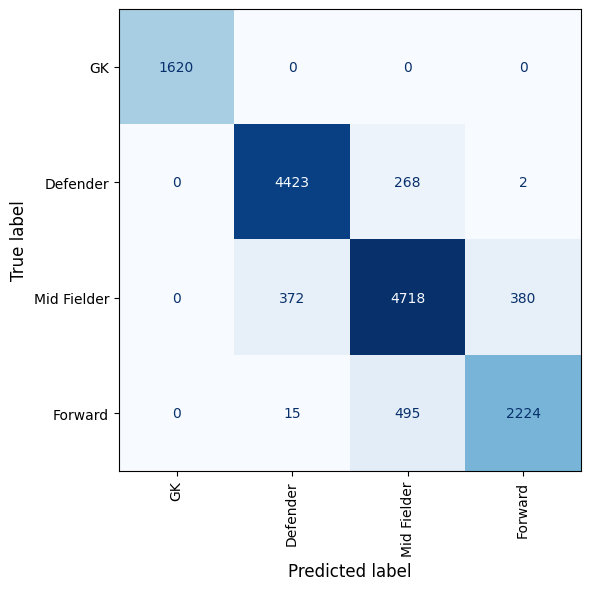

In [31]:
fn_plot_confusion_matrix(y_test, y_pred, class_labels)